In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import streamlit as st

C:\Users\DELL\AppData\Local\Temp\ipykernel_11080\1229400859.py:2: DtypeWarning: Columns (6,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ce_df = pd.read_csv("dataset\\ConsumerElectronics.csv")


New shape of DataFrame after removing duplicates: (1543981, 20)


C:\Users\DELL\AppData\Local\Temp\ipykernel_11080\1229400859.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ce_df["gmv"].fillna(ce_df["gmv"].median(), inplace=True)


MAE: 368.37167875133474
MSE: 1558110.4625058472
RMSE: 1248.2429501126162
R²: 0.9530093649723703
            order_date  predicted_gmv
0  2016-07-25 01:19:45     706.637294
1  2016-07-26 01:19:45     870.421639
2  2016-07-27 01:19:45     875.607583
3  2016-07-28 01:19:45     885.721238
4  2016-07-29 01:19:45    1266.459616
5  2016-07-30 01:19:45     587.199202
6  2016-07-31 01:19:45     587.199202
7  2016-08-01 01:19:45     888.010529
8  2016-08-02 01:19:45    1095.650055
9  2016-08-03 01:19:45     919.503948
10 2016-08-04 01:19:45    1352.234714
11 2016-08-05 01:19:45    1302.808520
12 2016-08-06 01:19:45    1131.313139
13 2016-08-07 01:19:45    1146.757917
14 2016-08-08 01:19:45     952.116925
15 2016-08-09 01:19:45    1511.023308
16 2016-08-10 01:19:45    1142.100793
17 2016-08-11 01:19:45     919.193703
18 2016-08-12 01:19:45     893.938187
19 2016-08-13 01:19:45     775.810595
20 2016-08-14 01:19:45     660.199571
21 2016-08-15 01:19:45     910.975764
22 2016-08-16 01:19:45    1246

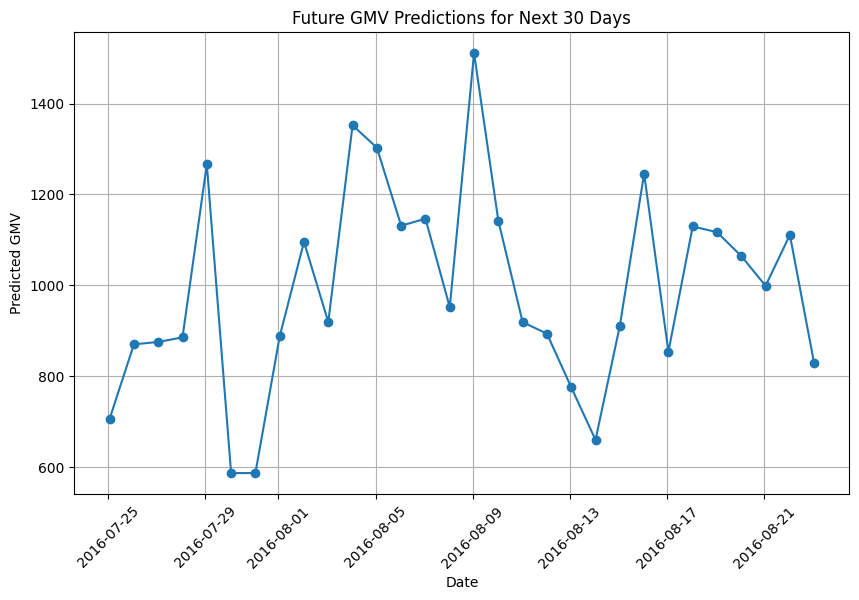

In [36]:
# Load the datasets
ce_df = pd.read_csv("dataset\\ConsumerElectronics.csv")

# Data Cleaning and Preprocessing
# Replace '\N' with NaN in the entire DataFrame
ce_df = ce_df.replace('\\N', pd.NA)

# Remove duplicates
ce_df = ce_df.drop_duplicates()
print(f"New shape of DataFrame after removing duplicates: {ce_df.shape}")

# Convert 'deliverybdays' and 'deliverycdays' to numeric
ce_df['deliverybdays'] = pd.to_numeric(ce_df['deliverybdays'], errors='coerce')
ce_df['deliverycdays'] = pd.to_numeric(ce_df['deliverycdays'], errors='coerce')

# Remove negative values from 'deliverybdays' and 'deliverycdays'
ce_df = ce_df[(ce_df['deliverybdays'] >= 1) & (ce_df['deliverycdays'] >= 1)]

# Fill NaN values in 'gmv' with the median
ce_df["gmv"] = pd.to_numeric(ce_df["gmv"], errors='coerce')
ce_df["gmv"].fillna(ce_df["gmv"].median(), inplace=True)

# Handle NaN values in 'product_analytic_vertical' by filling with mode
mode_value = ce_df['product_analytic_vertical'].mode()[0]
ce_df['product_analytic_vertical'] = ce_df['product_analytic_vertical'].fillna(mode_value)

# Drop columns that are not needed for analysis
columns_to_remove = ['fsn_id', 'pincode', 'units', 'cust_id', 'product_procurement_sla', 'Month', 'order_id']
ce_df = ce_df.drop(columns=columns_to_remove)

# Convert 'order_date' to datetime format
ce_df['order_date'] = pd.to_datetime(ce_df['order_date'])

# Time Series Forecasting for Future Sales Prediction
# Extract year, month, and day features
ce_df['year'] = ce_df['order_date'].dt.year
ce_df['month'] = ce_df['order_date'].dt.month
ce_df['day'] = ce_df['order_date'].dt.day

# Select features and target
features = ['year', 'month', 'day', 'deliverybdays', 'deliverycdays', 'product_mrp']
target = 'gmv'

# Split the data into train and test sets
X = ce_df[features]
y = ce_df[target]

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Predict future sales for the next 30 days using median values from historical data
future_dates = pd.date_range(start=ce_df['order_date'].max(), periods=30, freq='D')

# Use median values for 'deliverybdays', 'deliverycdays', and 'product_mrp'
median_deliverybdays = ce_df['deliverybdays'].median()
median_deliverycdays = ce_df['deliverycdays'].median()
median_product_mrp = ce_df['product_mrp'].median()

# Create a DataFrame for future dates
future_df = pd.DataFrame({
    'order_date': future_dates,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'deliverybdays': median_deliverybdays,
    'deliverycdays': median_deliverycdays,
    'product_mrp': median_product_mrp
})

# Predict future GMV
future_sales_pred = model.predict(future_df[features])

# Add predicted GMV to the future DataFrame
future_df['predicted_gmv'] = future_sales_pred

# Display future sales predictions
print(future_df[['order_date', 'predicted_gmv']])

# Plot future GMV predictions
plt.figure(figsize=(10, 6))
plt.plot(future_df['order_date'], future_df['predicted_gmv'], marker='o')
plt.title('Future GMV Predictions for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted GMV')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [37]:
print(ce_df['order_date'].min())
print(ce_df['order_date'].max())

2015-07-01 11:59:44
2016-07-25 01:19:45


In [2]:
md_df=pd.read_excel("dataset\\Media data and other information.xlsx")
on_df_15=pd.read_excel("dataset\\ONTARIO-2015.xlsx")
on_df_16=pd.read_excel("dataset\\ONTARIO-2016.xlsx")
pd_df=pd.read_excel("dataset\\Product Details.xlsx")

In [4]:
# Create a DataFrame to display the shape of all datasets
shape_data = {
    'Dataset': ['Media Data', 'Ontario 2015', 'Ontario 2016', 'Product Details'],
    'Shape': [md_df.shape, on_df_15.shape, on_df_16.shape, pd_df.shape]
}

shape_df = pd.DataFrame(shape_data)
print(shape_df)

           Dataset      Shape
0       Media Data    (76, 4)
1     Ontario 2015  (389, 27)
2     Ontario 2016  (390, 27)
3  Product Details    (74, 4)


In [5]:
media_and_product_df=pd.concat([md_df, pd_df], ignore_index=True)

# If you want to reset the index
media_and_product_df.reset_index(drop=True, inplace=True)
media_and_product_df.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,super_category,category,sub_category,vertical
0,NaN,NaN,Frequency,Percent,NaN,NaN,NaN,NaN
1,NaN,\N,5828,0.353464,NaN,NaN,NaN,NaN
2,NaN,AmplifierReceiver,4056,0.245994,NaN,NaN,NaN,NaN
3,NaN,AudioMP3Player,112892,6.846819,NaN,NaN,NaN,NaN
4,NaN,Binoculars,14599,0.885419,NaN,NaN,NaN,NaN


In [6]:
media_and_product_df.isnull().sum()

Unnamed: 0        150
Unnamed: 1         75
Unnamed: 2         74
Unnamed: 3         74
super_category     76
category           76
sub_category       76
vertical           76
dtype: int64

In [8]:
ontario_df=pd.concat([on_df_15, on_df_16], ignore_index=True)

# If you want to reset the index
ontario_df.reset_index(drop=True, inplace=True)
ontario_df.head(5)

,Station Name,AMHERSTBURG,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Province,ONTARIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Latitude,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Longitude,-83.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Elevation,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Climate Identifier,6130257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(f"The shape of media_and_product_df is: {media_and_product_df.shape}")
print(f"The shape of Ontario_df is: {ontario_df.shape}")

The shape of media_and_product_df is: (150, 8)
The shape of Ontario_df is: (779, 27)


In [12]:
# Step 1: Check for null values in media_and_product_df
media_null_percentage = (media_and_product_df.isnull().sum() / len(media_and_product_df)) * 100
print("Percentage of null values in media_and_product_df:\n")
print(media_null_percentage)

# Step 2: Check for null values in ontario_df
ontario_null_percentage = (ontario_df.isnull().sum() / len(ontario_df)) * 100
print("\nPercentage of null values in ontario_df:\n")
print(ontario_null_percentage)


Percentage of null values in media_and_product_df:

Unnamed: 0        100.000000
Unnamed: 1         50.000000
Unnamed: 2         49.333333
Unnamed: 3         49.333333
super_category     50.666667
category           50.666667
sub_category       50.666667
vertical           50.666667
dtype: float64

Percentage of null values in ontario_df:

Station Name     0.513479
AMHERSTBURG      1.283697
Unnamed: 2       5.905006
Unnamed: 3       5.905006
Unnamed: 4      41.206675
Unnamed: 5      43.003851
Unnamed: 6      97.946085
Unnamed: 7      47.240051
Unnamed: 8      93.709884
Unnamed: 9      47.240051
Unnamed: 10     93.709884
Unnamed: 11     47.240051
Unnamed: 12     93.709884
Unnamed: 13     47.240051
Unnamed: 14     93.709884
Unnamed: 15     41.206675
Unnamed: 16     98.459564
Unnamed: 17     41.206675
Unnamed: 18     97.689345
Unnamed: 19     41.206675
Unnamed: 20     97.304236
Unnamed: 21     41.206675
Unnamed: 22     98.716303
Unnamed: 23     99.743261
Unnamed: 24     99.743261
Unnamed:

In [22]:
# Step 1: Check for null values greater than 60% in media_and_product_df
media_null_percentage = (media_and_product_df.isnull().sum() / len(media_and_product_df)) * 100
media_null_greater_60 = media_null_percentage[media_null_percentage > 60]
print("Columns in media_and_product_df with null values greater than 60%:\n")
media_null_greater_60


Columns in media_and_product_df with null values greater than 60%:



Unnamed: 0    100.0
dtype: float64

In [23]:
# Step 2: Check for null values greater than 60% in ontario_df
ontario_null_percentage = (ontario_df.isnull().sum() / len(ontario_df)) * 100
ontario_null_greater_60 = ontario_null_percentage[ontario_null_percentage > 60]
print("\nColumns in ontario_df with null values greater than 60%:\n")
ontario_null_greater_60


Columns in ontario_df with null values greater than 60%:



Unnamed: 6     97.946085
Unnamed: 8     93.709884
Unnamed: 10    93.709884
Unnamed: 12    93.709884
Unnamed: 14    93.709884
Unnamed: 16    98.459564
Unnamed: 18    97.689345
Unnamed: 20    97.304236
Unnamed: 22    98.716303
Unnamed: 23    99.743261
Unnamed: 24    99.743261
Unnamed: 25    99.743261
Unnamed: 26    99.743261
dtype: float64

In [24]:
# Step 1: Remove columns with null values greater than 60% in media_and_product_df
media_null_percentage = (media_and_product_df.isnull().sum() / len(media_and_product_df)) * 100
media_columns_to_keep = media_null_percentage[media_null_percentage <= 60].index
media_and_product_df_cleaned = media_and_product_df[media_columns_to_keep]

print(f"media_and_product_df cleaned shape: {media_and_product_df_cleaned.shape}")


media_and_product_df cleaned shape: (150, 7)


In [25]:
# Step 2: Remove columns with null values greater than 60% in ontario_df
ontario_null_percentage = (ontario_df.isnull().sum() / len(ontario_df)) * 100
ontario_columns_to_keep = ontario_null_percentage[ontario_null_percentage <= 60].index
ontario_df_cleaned = ontario_df[ontario_columns_to_keep]

print(f"ontario_df cleaned shape: {ontario_df_cleaned.shape}")

ontario_df cleaned shape: (779, 14)


In [28]:
media_and_product_df_cleaned.head(3)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,super_category,category,sub_category,vertical
0,NaN,Frequency,Percent,NaN,NaN,NaN,NaN
1,\N,5828,0.353464,NaN,NaN,NaN,NaN
2,AmplifierReceiver,4056,0.245994,NaN,NaN,NaN,NaN


In [29]:
ontario_df_cleaned.head(3)

,Station Name,AMHERSTBURG,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 15,Unnamed: 17,Unnamed: 19,Unnamed: 21
0,Province,ONTARIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Latitude,42.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Longitude,-83.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
